In [224]:
from glob import glob
from PIL import Image
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import numpy as np
from pathlib import Path
from tqdm import tqdm
import shutil

# Работа с нашим датасетом

In [2]:
tree = ET.parse("../datasets/OUR_TEAM_DATA/annotations.xml")

list_of_annotations = [[[track.items()[0], box.items()] for box in track.findall("box")] for track in tree.findall("track")]
list_of_annotations = [x for y in list_of_annotations for x in y]

annotations = {}
for ann in list_of_annotations:
    n_frame = int(ann[1][0][1])
    x0, y0, x1, y1 = [float(a[1]) for a in ann[1][4:-1]]
    obj_id = int(ann[0][1])
    if n_frame not in annotations.keys():
        annotations[n_frame] = []
    annotations[n_frame].append((x0, y0, x1, y1, obj_id))

In [3]:
images = {int(path.split("frame_")[-1].split(".")[0]):path for path in glob("../datasets/OUR_TEAM_DATA/images/*.PNG")}

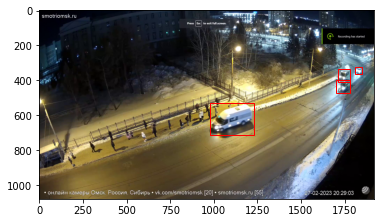

In [4]:
id_frame = 0

img_path = images[id_frame]
image = Image.open(img_path)

annotation = annotations[id_frame]

fig, ax = plt.subplots()
ax.imshow(image)
for x0, y0, x1, y1, _ in annotation:
    rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0,
                             linewidth=1, edgecolor='r', facecolor='none')

    ax.add_patch(rect)
plt.show()

In [5]:
img_w, img_h = image.size

In [6]:
def xml2yolo(x0, y0, x1, y1, img_w, img_h):
    """https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data
    """
    width = (x1 - x0) / img_w
    height = (y1 - y0) / img_h
    x_center = x0 / img_w + width / 2
    y_center = y0 / img_h + height / 2
    return x_center, y_center, width, height

In [7]:
yolo_annotations = [xml2yolo(x0, y0, x1, y1, img_w, img_h) for x0, y0, x1, y1, _ in annotation]

In [8]:
def print_yolo_annotations(image, yolo_annotations):
    img_w, img_h = image.size
    
    fig, ax = plt.subplots()
    ax.imshow(image)
    
    for x_center, y_center, width, height in yolo_annotations:
        
        abs_width = width * img_w
        abs_height = height * img_h
        
        abs_x0 = x_center * img_w - abs_width / 2
        abs_y0 = y_center * img_h - abs_height / 2
        
        rect = patches.Rectangle((abs_x0, abs_y0), abs_width, abs_height,
                                 linewidth=1, edgecolor='r', facecolor='none')

        ax.add_patch(rect)
        
    plt.show()

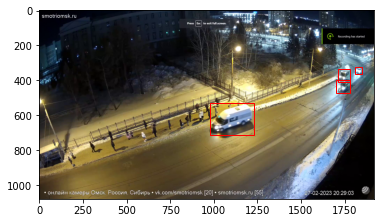

In [9]:
print_yolo_annotations(image, yolo_annotations)

In [41]:
yolo_annotations = {k:[xml2yolo(v_[0], v_[1], v_[2], v_[3], img_w, img_h) for v_ in v] for k, v in annotations.items()}

In [46]:
our_dataset = {}

In [47]:
for i, image_path in images.items():
    our_dataset[image_path] = yolo_annotations[i]

# GRAM

In [155]:
gram_images = glob("../datasets/GRAM-RTMv4/Images/*/*.jpg")
gram_dataset = {}
for image_path in tqdm(gram_images):
    subset_name = image_path.split("/")[4]
    image_number = int(image_path.split("/")[5].split(".")[0][5:])
    annotation_path = f"../datasets/GRAM-RTMv4/Annotations/{subset_name}/xml/{image_number}.xml"
    if Path(annotation_path).exists():
        annotations = []
        size = ET.parse(annotation_path).find("size")
        img_w = int(size.find("width").text)
        img_h = int(size.find("height").text)
        for obj in ET.parse(annotation_path).findall("object"):
            if obj.find("class").text == 'car':
                bbox = obj.find("bndbox")
                x0 = int(bbox.find("xmin").text)
                y0 = int(bbox.find("ymin").text)
                x1 = int(bbox.find("xmax").text)
                y1 = int(bbox.find("ymax").text)
                annotations.append(xml2yolo(x0, y0, x1, y1, img_w, img_h))
        gram_dataset[image_path] = annotations

100%|██████████| 40345/40345 [13:41<00:00, 49.13it/s]


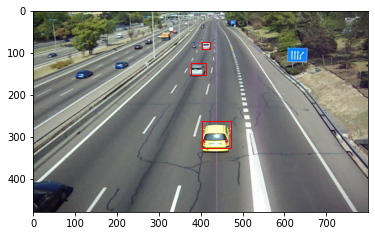

In [164]:
image_path, annotations = [i for i in gram_dataset.items()][0]
image = Image.open(image_path)
print_yolo_annotations(image, annotations)

# Теперь создадим дирректорию для обучения

In [232]:
#!rm -rf train_tmp_dataset

In [233]:
SPLIT_RATIO = 0.7, 0.15, 0.15

dataset_dir = Path("train_tmp_dataset")
dataset = {**our_dataset, **gram_dataset}

list_of_images, list_of_annotations = [], []
for path, ann in dataset.items():
    list_of_images.append(path)
    list_of_annotations.append(ann)

len_ = len(dataset)

ratios = ((0, round(SPLIT_RATIO[0] * len_)),
(round(len_ * SPLIT_RATIO[0]), round(len_ * (SPLIT_RATIO[0] + SPLIT_RATIO[1]))),
(round(len_ * (SPLIT_RATIO[0] + SPLIT_RATIO[1])), len_))

In [234]:
for subset, ratio in zip(["train", "val", "test"], ratios):
    
    path_to_images = dataset_dir / Path("images") / Path(subset)
    path_to_images.mkdir(parents=True, exist_ok=True)
    
    path_to_labels = dataset_dir / Path("labels") / Path(subset)
    path_to_labels.mkdir(parents=True, exist_ok=True)
    
    lim, lan = list_of_images[ratio[0]:ratio[1]], list_of_annotations[ratio[0]:ratio[1]]
    
    for image_path, annotations in tqdm(zip(lim, lan)):
        # copy image
        src = image_path
        dst = (path_to_images / Path(image_path).name).as_posix()
        shutil.copy(src=src, dst=dst)
        
        # 
        txt_content = "\n".join([" ".join(["0"] + [str(cc)[:8] for cc in ann]) for ann in annotations])
        ann_file_path = (path_to_labels / Path(Path(image_path).stem + ".txt")).as_posix()
        with open(ann_file_path, "w") as f:
            f.write(txt_content)

28612it [22:56, 20.78it/s]
6131it [04:31, 22.59it/s]
6131it [04:32, 22.47it/s]


In [245]:
yaml_content = f"""
path: /mnt/c/Users/germa/projects/itmo/traffic_counting/cars_detection/train_tmp_dataset
train: images/train
val: images/val
test: images/test

names:
    0: car
"""

posix_path_to_yaml = (dataset_dir / Path("custom_dataset.yml")).as_posix()

with open(posix_path_to_yaml, "w") as f:
    f.write(yaml_content)

# Обучение

In [1]:
from ultralytics import YOLO

/home/germa/miniconda3/envs/traffic_counting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = YOLO("yolov8m.pt")

In [5]:
for optimizer in ['SGD', 'Adam', 'RMSProp']:
    for lr0 in [0.1, 0.01, 0.001]:
        name = f"{optimizer}_{lr0}"
        model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=SGD_0.1, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=Fa

ClearML Task: created new task id=36f3e26504874d73b838e28069b09688
2023-03-22 23:11:56,352 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/a88eb2adf79b4df9b174d32da043b7e7/experiments/36f3e26504874d73b838e28069b09688/output/log


WARNING ⚠️ TensorBoard not initialized correctly, not logging this run. 'NoneType' object is not callable
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
optimizer: SGD(lr=0.01) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias
train: Scanning /mnt/c/Users/germa/projects/itmo/traffic_counting/cars_detection/train_tmp_dataset/labels/train.cache... 11704 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11704/11704 [00:00<?, ?it/s]


ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


val: Scanning /mnt/c/Users/germa/projects/itmo/traffic_counting/cars_detection/train_tmp_dataset/labels/val.cache... 6131 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6131/6131 [00:00<?, ?it/s]
Plotting labels to runs/detect/SGD_0.1/labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/SGD_0.1
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       1/10      6.34G     0.7952     0.6123     0.9999         20        640: 100%|██████████| 732/732 [06:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 192/192 [01:36<00:00,  1.99it/s]
                   all       6131      13655      0.884      0.867      0.945       0.78

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/10      6.69G     0.6768     0.4006     0.9205         24      

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [6]:
optimizer = 'SGD'
lr0 = 0.01
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=SGD_0.01, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=F

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [7]:
optimizer = 'SGD'
lr0 = 0.001
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=SGD_0.001, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [8]:
optimizer = 'Adam'
lr0 = 0.1
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=Adam_0.1, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=F

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [9]:
optimizer = 'Adam'
lr0 = 0.01
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=Adam_0.01, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [11]:
optimizer = 'Adam'
lr0 = 0.001
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=Adam_0.001, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [12]:
optimizer = 'RMSProp'
lr0 = 0.1
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RMSProp_0.1, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nm

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [13]:
optimizer = 'RMSProp'
lr0 = 0.01
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.55 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RMSProp_0.01, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_n

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌

In [ ]:
optimizer = 'RMSProp'
lr0 = 0.001
name = f"{optimizer}_{lr0}"
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10, name=name)

New https://pypi.org/project/ultralytics/8.0.56 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=RMSProp_0.001, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_

In [ ]:
model.train(data="train_tmp_dataset/custom_dataset.yml", epochs=10)

Ultralytics YOLOv8.0.53 🚀 Python-3.9.16 torch-1.13.1+cu117 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 8192MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=train_tmp_dataset/custom_dataset.yml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int

FileNotFoundError: Dataset 'train_tmp_dataset/custom_dataset.yml' for task=detect not found ❌